In [214]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [215]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CIFAR10Albumentations(datasets.CIFAR10):
    def __init__(self, root, train=True, download=True, transform=None, albumentations_transform=None):
        super(CIFAR10Albumentations, self).__init__(root, train=train, download=download, transform=transform)
        self.albumentations_transform = albumentations_transform

    def __getitem__(self, index):
        # Fetching the image and label from the CIFAR10 dataset
        img, label = super(CIFAR10Albumentations, self).__getitem__(index)

        # Convert PIL image to numpy array
        img = np.array(img)

        # Apply Albumentations transformations
        if self.albumentations_transform:
            augmented = self.albumentations_transform(image=img)
            img = augmented['image']

        return img, label

# Dataset mean and std for normalization
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Define the train transformations using Albumentations
train_transforms = A.Compose([
                              A.HorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
                              A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),  # ShiftScaleRotate
                              A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=tuple([x * 255 for x in mean]), p=0.5),  # CoarseDropout
                              A.Normalize(mean=mean, std=std),  # Normalize
                              ToTensorV2()  # Convert to tensor
                              ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [216]:
# train = datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified


In [217]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_dataset = CIFAR10Albumentations(root='./data', train=True, download=True, albumentations_transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


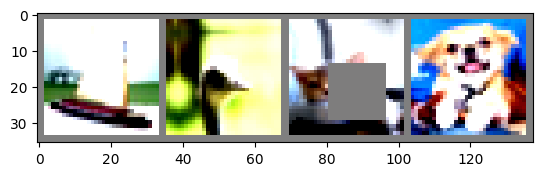

ship  bird  cat   dog  


In [218]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [219]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolution Block 1 - Standard Convolution
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=2, stride=2),  # Reduced channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2, stride=2),  # Reduced channels
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2, stride=2),  # Adjusted channels
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )  # Receptive field: 9

        # Convolution Block 2 - Standard Convolution
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2, stride=2, groups=64),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2, stride=2, groups=128),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2, stride=2, groups=128),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value),
        )  # Receptive field: 14

        # Convolution Block 3 - Depthwise Separable Convolution with Dilation
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=2, stride=2, groups=256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),  # Pointwise
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=4, stride=2, groups=256, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_value),
        )  # Receptive field: 32 (approx, considering dilations)

        # Convolution Block 4 - Depthwise Separable Convolution
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=4, stride=2, groups=256, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),  # Pointwise
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=2, stride=2, groups=64),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=2, groups=256), # Stride 2 here


            # nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),  # Pointwise
            # nn.ReLU(),
            # nn.BatchNorm2d(64)
        )  # Receptive field: 44 (approx)

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = self.convblock5(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [220]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 17, 17]             448
              ReLU-2           [-1, 16, 17, 17]               0
       BatchNorm2d-3           [-1, 16, 17, 17]              32
            Conv2d-4           [-1, 32, 10, 10]           4,640
              ReLU-5           [-1, 32, 10, 10]               0
       BatchNorm2d-6           [-1, 32, 10, 10]              64
            Conv2d-7             [-1, 64, 6, 6]          18,496
              ReLU-8             [-1, 64, 6, 6]               0
       BatchNorm2d-9             [-1, 64, 6, 6]             128
          Dropout-10             [-1, 64, 6, 6]               0
           Conv2d-11            [-1, 128, 4, 4]           1,280
             ReLU-12            [-1, 128, 4, 4]               0
      BatchNorm2d-13            [-1, 128, 4, 4]             256
           Conv2d-14            [-

In [221]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [222]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.9196670055389404 Batch_id=97 Accuracy=20.59: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s]



Test set: Average loss: 1.8671, Accuracy: 3160/10000 (31.60%)

EPOCH: 1


Loss=1.7681589126586914 Batch_id=97 Accuracy=32.01: 100%|██████████| 98/98 [00:12<00:00,  7.67it/s]



Test set: Average loss: 1.6663, Accuracy: 3907/10000 (39.07%)

EPOCH: 2


Loss=1.7331453561782837 Batch_id=97 Accuracy=36.01: 100%|██████████| 98/98 [00:12<00:00,  7.56it/s]



Test set: Average loss: 1.5634, Accuracy: 4255/10000 (42.55%)

EPOCH: 3


Loss=1.6549192667007446 Batch_id=97 Accuracy=38.93: 100%|██████████| 98/98 [00:12<00:00,  7.55it/s]



Test set: Average loss: 1.4780, Accuracy: 4561/10000 (45.61%)

EPOCH: 4


Loss=1.5934580564498901 Batch_id=97 Accuracy=41.19: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 1.4267, Accuracy: 4735/10000 (47.35%)

EPOCH: 5


Loss=1.4901214838027954 Batch_id=97 Accuracy=42.54: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]



Test set: Average loss: 1.4033, Accuracy: 4801/10000 (48.01%)

EPOCH: 6


Loss=1.5111348628997803 Batch_id=97 Accuracy=44.28: 100%|██████████| 98/98 [00:13<00:00,  7.14it/s]



Test set: Average loss: 1.3456, Accuracy: 4983/10000 (49.83%)

EPOCH: 7


Loss=1.4589247703552246 Batch_id=97 Accuracy=45.28: 100%|██████████| 98/98 [00:13<00:00,  7.44it/s]



Test set: Average loss: 1.3463, Accuracy: 5013/10000 (50.13%)

EPOCH: 8


Loss=1.3783761262893677 Batch_id=97 Accuracy=46.42: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 1.2810, Accuracy: 5274/10000 (52.74%)

EPOCH: 9


Loss=1.3641622066497803 Batch_id=97 Accuracy=47.16: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 1.2631, Accuracy: 5335/10000 (53.35%)

EPOCH: 10


Loss=1.4473391771316528 Batch_id=97 Accuracy=48.12: 100%|██████████| 98/98 [00:13<00:00,  7.37it/s]



Test set: Average loss: 1.2299, Accuracy: 5491/10000 (54.91%)

EPOCH: 11


Loss=1.305370807647705 Batch_id=97 Accuracy=49.11: 100%|██████████| 98/98 [00:12<00:00,  7.55it/s]



Test set: Average loss: 1.2250, Accuracy: 5535/10000 (55.35%)

EPOCH: 12


Loss=1.4017257690429688 Batch_id=97 Accuracy=49.93: 100%|██████████| 98/98 [00:13<00:00,  7.52it/s]



Test set: Average loss: 1.1812, Accuracy: 5681/10000 (56.81%)

EPOCH: 13


Loss=1.2967700958251953 Batch_id=97 Accuracy=50.82: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]



Test set: Average loss: 1.2009, Accuracy: 5569/10000 (55.69%)

EPOCH: 14


Loss=1.3283158540725708 Batch_id=97 Accuracy=50.55: 100%|██████████| 98/98 [00:13<00:00,  7.38it/s]



Test set: Average loss: 1.1857, Accuracy: 5590/10000 (55.90%)

EPOCH: 15


Loss=1.3533549308776855 Batch_id=97 Accuracy=51.93: 100%|██████████| 98/98 [00:13<00:00,  7.42it/s]



Test set: Average loss: 1.1542, Accuracy: 5738/10000 (57.38%)

EPOCH: 16


Loss=1.263954758644104 Batch_id=97 Accuracy=52.37: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s]



Test set: Average loss: 1.1546, Accuracy: 5785/10000 (57.85%)

EPOCH: 17


Loss=1.2905168533325195 Batch_id=97 Accuracy=52.91: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 1.1417, Accuracy: 5813/10000 (58.13%)

EPOCH: 18


Loss=1.301373839378357 Batch_id=97 Accuracy=53.38: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 1.1367, Accuracy: 5868/10000 (58.68%)

EPOCH: 19


Loss=1.2925996780395508 Batch_id=97 Accuracy=53.75: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s]



Test set: Average loss: 1.1217, Accuracy: 5941/10000 (59.41%)



In [223]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), groups=64)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), groups=128)
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [224]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 13
conv_layers


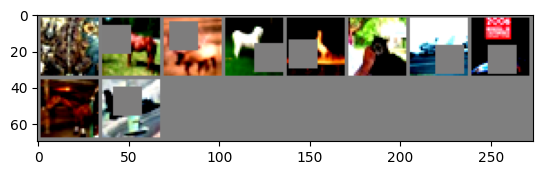

In [225]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

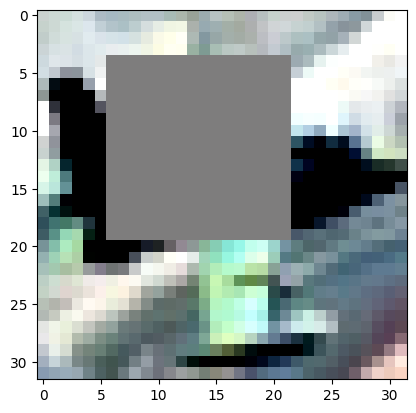

In [226]:
image = images[9]
imshow(image)

In [227]:
image = image.unsqueeze(0)
image = image.to(device)

In [228]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

13
torch.Size([1, 16, 17, 17])
torch.Size([1, 32, 10, 10])
torch.Size([1, 64, 6, 6])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 3, 3])
torch.Size([1, 256, 3, 3])
torch.Size([1, 256, 3, 3])
torch.Size([1, 256, 3, 3])
torch.Size([1, 512, 4, 4])
torch.Size([1, 256, 4, 4])
torch.Size([1, 256, 4, 4])
torch.Size([1, 64, 3, 3])
torch.Size([1, 10, 3, 3])


In [229]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(17, 17)
(10, 10)
(6, 6)
(4, 4)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(4, 4)
(4, 4)
(4, 4)
(3, 3)
(3, 3)


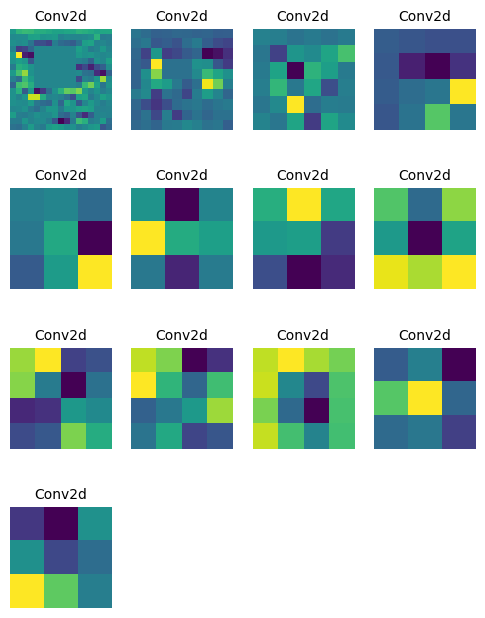

In [230]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

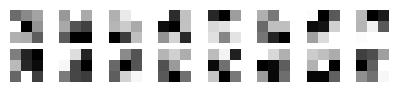

In [231]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()